# Figure 3 | Differentially expressed genes distinguish adjacent cell types in the anterior thalamic nuclei.

In [1]:
%load_ext autoreload
%autoreload 2

In [156]:
import numpy as np
import pandas as pd
import scanpy as sc

import sys
sys.path.append('/code/')
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_erode as cerode
from thalamus_merfish_analysis import ccf_plots as cplots

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import colorcet as cc

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
results_dir = '../../results'

## Load thalamus data

In [4]:
# Load the full thalamus anndata object
adata_th = abc.load_standard_thalamus(data_structure='adata')

# Subset to just the left hemisphere
adata_th_left = adata_th[adata_th.obs['left_hemisphere']].copy()

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

In [6]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images = cerode.merge_substructures(ccf_images, ccf_level='structure')

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(adata_th.obs[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [7]:
# Load the CCF structures image - just the left hemisphere
ccf_images_left = abc.get_ccf_labels_image(subset_to_left_hemi=True)

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images_left = cerode.merge_substructures(ccf_images_left, ccf_level='structure')

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(adata_th_left.obs[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries_left = cimg.sectionwise_label_erosion(ccf_images_left, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [8]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

In [9]:
# load the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters

abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() 

## Load data for just the ATN cells

In [10]:
# get the cluster annotations for the ATN
nucleus = ['AD', 'AM', 'AV']
obs_annot = abc.get_obs_from_annotated_clusters(nucleus, adata_th.obs)

# use the list of ATN-specific clusters from obs_annot to filter & reset the 
# cluster col in the full anndata object
obs_annot.loc[:,'cluster'] = obs_annot.loc[:,'cluster'].cat.remove_unused_categories()
cluster_list_ATN = sorted(obs_annot['cluster'].cat.categories)
# ATN-subset of the full anndata object
adata_ATN = adata_th[adata_th.obs['cluster'].isin(cluster_list_ATN)].copy()
# reset both cluster and supertype categories
for level in ['supertype','cluster']:
    adata_ATN.obs.loc[:,level] = adata_ATN.obs.loc[:,level].cat.remove_unused_categories()
    
# adata_ATN.obs.loc[:,'cluster'] = adata_ATN.obs.loc[:,'cluster'].cat.reorder_categories(cluster_list_ATN, ordered=True)

## Fig. 3A | Anterior thalamic nuclei (ATN) supertypes

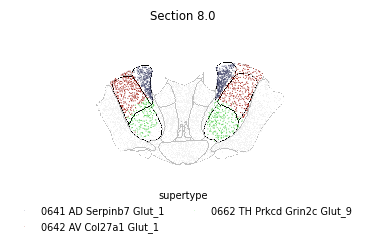

In [11]:
# set kwargs fpr annotated cluster plots
kwargs_cluster_annotations = dict(
    section_col=z_col,
    x_col=x_col,
    y_col=y_col,
    point_size=0.5,
    figsize=(4, 2),
    face_palette=None,
    edge_color='silver'
    )

# get the cluster annotations for the nucleus of interest
nucleus = ['AD', 'AM', 'AV']
obs_annot = abc.get_obs_from_annotated_clusters(nucleus, adata_th.obs)

# Let's look at the cell types in the ATN in one sample section
sections_to_plot = [cplots.TH_EXAMPLE_Z_SECTIONS[0]]
nuclei_highlight = ['AD', 'AMd', 'AMv', 'AV', 'AV']
taxonomy_level = 'supertype'

plt.rcParams.update({'font.size': 7})
figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                    ccf_images,
                                    boundary_img=ccf_boundaries,
                                    bg_cells=adata_th.obs, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=sections_to_plot,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    **kwargs_cluster_annotations)
figs_annot[0].savefig(f'{results_dir}/fig3A_supertype_annotations_z80_ATN.pdf', 
                      transparent=True, bbox_inches='tight')
figs_annot[0].savefig(f'{results_dir}/fig3A_supertype_annotations_z80_ATN.png', 
                      transparent=True, bbox_inches='tight', dpi=1200)

## Fig. 3C | Dotplot of differentially expressed genes (DEGs) in the 3 ATN supertypes

### Fig. S2 | Exploratory DEG dotplot (5 genes per supertype)

In [12]:
supertypes_ATN = ['0642 AV Col27a1 Glut_1', 
                  '0641 AD Serpinb7 Glut_1',
                  '0662 TH Prkcd Grin2c Glut_9']

supertypes_ATN = adata_ATN.obs['supertype'].cat.categories

['Adcy2', 'Slc17a7', 'Syndig1l', 'Nptx2', 'Nxph1', 'Car4', 'Lhfp', 'Col27a1', 'Zbtb16', 'Rgs6', 'Calb1', 'Ramp3', 'Tnnt1', 'Tox', 'Tmem132c']


/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


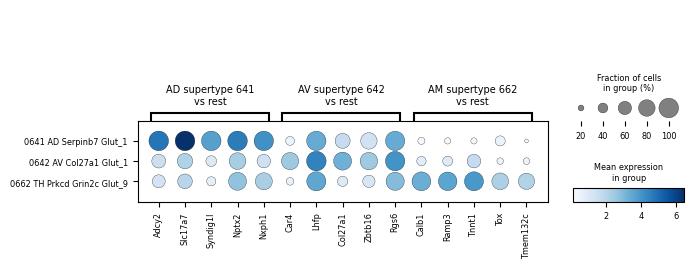

In [13]:
supertypes_ATN = [
    '0641 AD Serpinb7 Glut_1',
    '0642 AV Col27a1 Glut_1',
    '0662 TH Prkcd Grin2c Glut_9'
]
deg_list_ATN_st = []

for st in supertypes_ATN:
    sc.tl.rank_genes_groups(adata_ATN, groupby="supertype", groups=[st],
                            reference='rest', n_genes=5, method="wilcoxon")
    deg_list_ATN_st.extend(sc.get.rank_genes_groups_df(adata_ATN, group=st).names.to_list())

print(deg_list_ATN_st)

# manually set gene group labels for dotplot
var_group_positions_st = [[0,4], [5,9], 
                       [10,14]]
var_group_labels_st = ['AD supertype 641\nvs rest', 
                    'AV supertype 642\nvs rest',
                    'AM supertype 662\nvs rest']
# dotplot
dotplot_st_explore = sc.pl.dotplot(adata_ATN,
                                  deg_list_ATN_st,
                                #   sorted(list(set(deg_list_ATN))), 
                                  groupby='supertype', 
                                  dendrogram=False,
                                  cmap='Blues',
                                  var_group_positions=var_group_positions_st,
                                  var_group_labels=var_group_labels_st,
                                  var_group_rotation=0)
dotplot_st.savefig(f'{results_dir}/figS2A_ATN_supertype_degs_dotplot_5perST.pdf',
                    transparent=True, 
                    bbox_inches='tight')

### Curated dotplot for Fig. 3C (2 manually selected DEGs per supertype)

In [14]:
markers_manual_ATN_st = [
    # AD
    'Adcy2', 'Slc17a7', 'Syndig1l',
    # AV 
    'Car4', 'Col27a1', 'Zbtb16',
    # AM
    # 'Calb1', 
    'Ramp3', # 'Tnnt1',
    'Tox', 'Tmem132c',
    ]

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


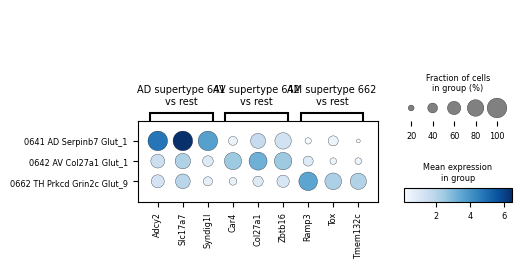

In [15]:
# manually set gene group labels for dotplot
var_group_positions_st = [[0,2], 
                          [3,5], 
                          [6,8]]
var_group_labels_st = ['AD supertype 641\nvs rest', 
                    'AV supertype 642\nvs rest',
                    'AM supertype 662\nvs rest']

# dotplot
dotplot_st = sc.pl.dotplot(adata_ATN,
              markers_manual_ATN_st,
            #   sorted(list(set(deg_list_ATN))), 
              groupby='supertype', 
              dendrogram=False,
              cmap='Blues',
              var_group_positions=var_group_positions_st,
              var_group_labels=var_group_labels_st,
              var_group_rotation=0,
              return_fig=True)
dotplot_st.savefig(f'{results_dir}/degs_curated_dotplot_ATN_supertype.pdf',
                    transparent=True, bbox_inches='tight')

## Fig. 3B | Gene expression of supertype DEGs in the ATN

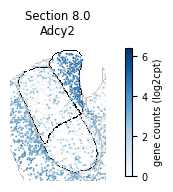

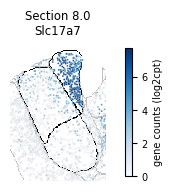

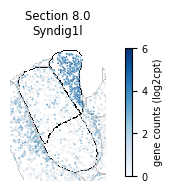

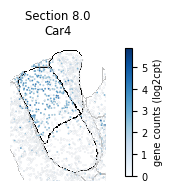

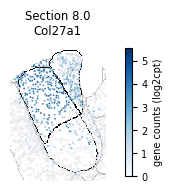

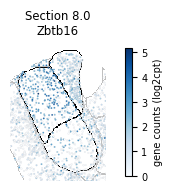

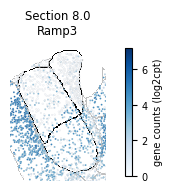

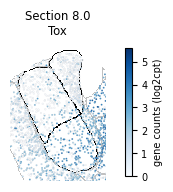

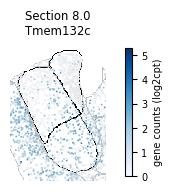

In [16]:
# show outlines for all the ATN
nuclei_ATN = ['AD', 'AV', 'AMd', 'AMv']
sections_ATN = [7.8, 8.0, 8.2]

kwargs_ATN_expr = dict(
    boundary_img=ccf_boundaries_left,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    cmap='Blues',
    # cb_vmin_vmax=(0,7),
    point_size=1.5,
    edge_color='silver',
    edgecolors='silver',
    linewidths=0.1,
    figsize=(1.8,1.8),
    )

# AD DEGs
for gene in markers_manual_ATN_st:
    fig = cplots.plot_expression_ccf(adata_th_left, 
                               gene, 
                               ccf_images_left,
                               sections=[8.0],
                               highlight=nuclei_ATN,
                               zoom_to_highlighted=True,
                               **kwargs_ATN_expr)
    fig[0].savefig(f'{results_dir}/degs_ATN_supertypes_{gene}.pdf',
                   transparent=True, bbox_inches='tight', dpi=1200)
    fig[0].savefig(f'{results_dir}/degs_ATN_supertypes_{gene}.png',
                   transparent=True, bbox_inches='tight', dpi=1200)

## Fig. 3D | ATN clusters

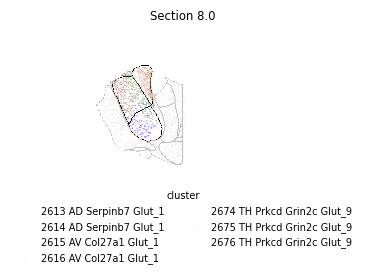

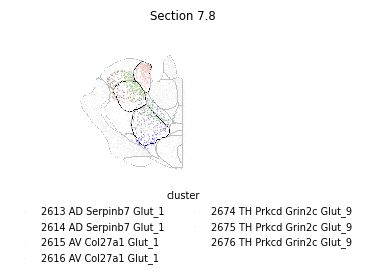

In [28]:
# set kwargs fpr annotated cluster plots
kwargs_cluster_annotations = dict(
    section_col=z_col,
    x_col=x_col,
    y_col=y_col,
    point_size=0.5,
    figsize=(4, 2),
    face_palette=None,
    edge_color='silver'
    )

# get the cluster annotations for the nucleus of interest
nucleus = ['AD', 'AM', 'AV']
obs_annot_left = abc.get_obs_from_annotated_clusters(nucleus, adata_th_left.obs)

# Let's look at the cell types in the ATN in one sample section
sections_ATN_clusters = [8.0, 7.8]
nuclei_highlight = ['AD', 'AMd', 'AMv', 'AV', 'AV']
taxonomy_level = 'cluster'

plt.rcParams.update({'font.size': 7})
figs_annot = cplots.plot_ccf_overlay(obs_annot_left, 
                                    ccf_images_left,
                                    boundary_img=ccf_boundaries_left,
                                    bg_cells=adata_th_left.obs, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=sections_ATN_clusters,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    **kwargs_cluster_annotations)
figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_z80_ATN.pdf', 
                      transparent=True, bbox_inches='tight')
figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_z80_ATN.png', 
                      transparent=True, bbox_inches='tight', dpi=1200)

In [107]:
# set kwargs fpr annotated cluster plots
kwargs_cluster_annotations = dict(
    section_col=z_col,
    x_col=x_col,
    y_col=y_col,
    point_size=4,
    figsize=(1.75, 1.5),
    face_palette=None,
    edge_color='silver',
    )

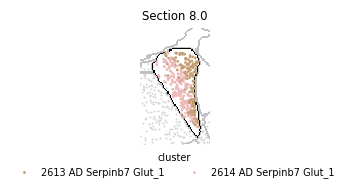

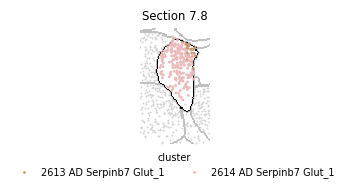

In [108]:
# AD clusters
sections_ATN_clusters = [8.0, 7.8]
nuclei_highlight = ['AD']
obs_annot_AD = abc.get_obs_from_annotated_clusters(nuclei_highlight, adata_th_left.obs)
taxonomy_level = 'cluster'
custom_xy_lims_AD = [4.4, 5.0, 5.55, 4.55]  # manually set zoom so the two sections' 
                                            # plots are the same size

plt.rcParams.update({'font.size': 7})
for sec in sections_ATN_clusters:
    figs_annot = cplots.plot_ccf_overlay(obs_annot_AD, 
                                        ccf_images_left,
                                        boundary_img=ccf_boundaries_left,
                                        bg_cells=adata_th_left.obs, 
                                        ccf_highlight=nuclei_highlight,
                                        point_hue=taxonomy_level, 
                                        sections=[sec],
                                        point_palette=abc_palettes[taxonomy_level],
                                        legend='cells',
                                        custom_xy_lims=custom_xy_lims_AD,
                                        **kwargs_cluster_annotations)
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight}_z{int(sec*10)}.pdf', 
                        transparent=True, bbox_inches='tight')
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight}_z{int(sec*10)}.png', 
                        transparent=True, bbox_inches='tight', dpi=1200)

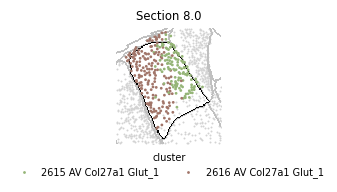

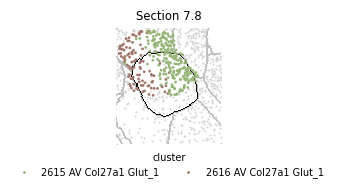

In [109]:
# AV clusters
sections_ATN_clusters = [8.0, 7.8]
nuclei_highlight = ['AV']
obs_annot_AV = abc.get_obs_from_annotated_clusters(nuclei_highlight, adata_th_left.obs)
taxonomy_level = 'cluster'
custom_xy_lims_AV = [4.0, 5.0, 5.90, 4.8]  # manually set zoom so the two sections' 
                                            # plots are the same size

plt.rcParams.update({'font.size': 7})
for sec in sections_ATN_clusters:
    figs_annot = cplots.plot_ccf_overlay(obs_annot_AV, 
                                        ccf_images_left,
                                        boundary_img=ccf_boundaries_left,
                                        bg_cells=adata_th_left.obs, 
                                        ccf_highlight=nuclei_highlight,
                                        point_hue=taxonomy_level, 
                                        sections=[sec],
                                        point_palette=abc_palettes[taxonomy_level],
                                        legend='cells',
                                        custom_xy_lims=custom_xy_lims_AV,
                                        **kwargs_cluster_annotations)
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight}_z{int(sec*10)}.pdf', 
                        transparent=True, bbox_inches='tight')
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight}_z{int(sec*10)}.png', 
                        transparent=True, bbox_inches='tight', dpi=1200)

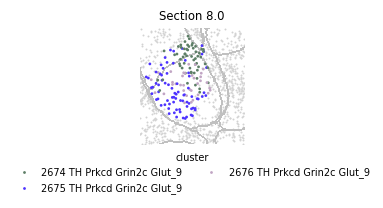

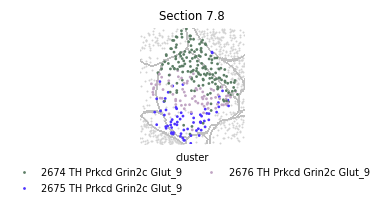

In [110]:
# AM clusters
sections_ATN_clusters = [8.0, 7.8]
nuclei_highlight = ['AM']
obs_annot_AM = abc.get_obs_from_annotated_clusters(nuclei_highlight, adata_th_left.obs)
taxonomy_level = 'cluster'
custom_xy_lims_AM = [4.35, 5.3, 6.35, 5.3]  # manually set zoom so the two sections' 
                                            # plots are the same size

plt.rcParams.update({'font.size': 7})
for sec in sections_ATN_clusters:
    figs_annot = cplots.plot_ccf_overlay(obs_annot_AM, 
                                        ccf_images_left,
                                        boundary_img=ccf_boundaries_left,
                                        bg_cells=adata_th_left.obs, 
                                        ccf_highlight=nuclei_highlight,
                                        point_hue=taxonomy_level, 
                                        sections=[sec],
                                        point_palette=abc_palettes[taxonomy_level],
                                        legend='cells',
                                        custom_xy_lims=custom_xy_lims_AM,
                                        **kwargs_cluster_annotations)
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight}_z{int(sec*10)}.pdf', 
                        transparent=True, bbox_inches='tight')
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight}_z{int(sec*10)}.png', 
                        transparent=True, bbox_inches='tight', dpi=1200)

## Fig. 3H | Dotplot of differentially expressed genes (DEGs) in the 7 ATN clusters

In [18]:
# manual medial-to-lateral cluster ordering for dotplots
clusters_med_to_lat_ATN = [
    '2613 AD Serpinb7 Glut_1',
    '2614 AD Serpinb7 Glut_1',
    '2615 AV Col27a1 Glut_1',
    '2616 AV Col27a1 Glut_1',
    '2674 TH Prkcd Grin2c Glut_9',
    '2676 TH Prkcd Grin2c Glut_9',
    '2675 TH Prkcd Grin2c Glut_9',
]

# reorder by manual medial-to-lateral ordering
adata_ATN.obs.loc[:,'cluster'] = adata_ATN.obs.loc[:,'cluster'].cat.reorder_categories(clusters_med_to_lat_ATN, ordered=True)
adata_ATN.obs.loc[:,'cluster'].cat.categories

Index(['2613 AD Serpinb7 Glut_1', '2614 AD Serpinb7 Glut_1',
       '2615 AV Col27a1 Glut_1', '2616 AV Col27a1 Glut_1',
       '2674 TH Prkcd Grin2c Glut_9', '2676 TH Prkcd Grin2c Glut_9',
       '2675 TH Prkcd Grin2c Glut_9'],
      dtype='object')

### Exploratory dotplots for ATN cluster DEGs (5 genes per neighboring cluster pair)

In [19]:
# Helper function to get the top DEGs for a given cluster
def get_rank_genes_list(adata, 
                        groupby='cluster', 
                        group='', 
                        reference='rest', 
                        n_genes=5):
    # find DEGs
    sc.tl.rank_genes_groups(adata, 
                            groupby="cluster", 
                            groups=[group],
                            reference=reference, 
                            n_genes=n_genes, 
                            method="wilcoxon")
    # get DEGs
    deg_list = sc.get.rank_genes_groups_df(adata, group=group).names.to_list()
    
    return deg_list

['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib', 'Sox2', 'Chrm3', 'Stxbp6', 'Kcnh8', 'Klhl14']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib', 'Sox2', 'Chrm3', 'Stxbp6', 'Kcnh8', 'Klhl14', 'Epha4', 'Grm1', 'Rorb', 'Kitl', 'Slc17a7']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib', 'Sox2', 'Chrm3', 'Stxbp6', 'Kcnh8', 'Klhl14', 'Epha4', 'Grm1', 'Rorb', 'Kitl', 'Slc17a7', 'Pdyn', 'Fbn2', 'Sox2', 'Grik1', 'Rgs6', 'Pdyn', 'Col27a1', 'Tnnt1', 'Grik1', 'Tmem132c']
['Calb2', 'Cnr1'

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


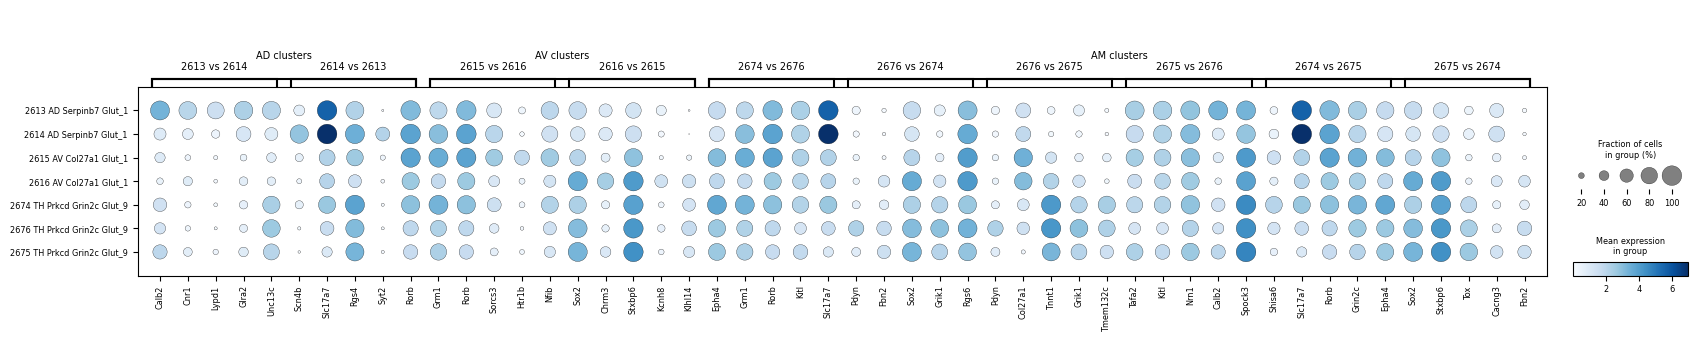

In [20]:
deg_paired_list_ATN = []
n_genes = 5

# AD clusters vs each other
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2613 AD Serpinb7 Glut_1', 
                                               reference='2614 AD Serpinb7 Glut_1',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
# sc.pl.rank_genes_groups(adata_ATN, group=cluster_list_ATN[0])
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2614 AD Serpinb7 Glut_1', 
                                               reference='2613 AD Serpinb7 Glut_1',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)

# AV clusters vs each other
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2615 AV Col27a1 Glut_1',
                                               reference='2616 AV Col27a1 Glut_1',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2616 AV Col27a1 Glut_1',
                                               reference='2615 AV Col27a1 Glut_1',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)

# AM clusters vs each other -- medial -> lateral : 2674 -> 2676 -> 2675
# 2676 vs 2674
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2674 TH Prkcd Grin2c Glut_9', 
                                               reference='2676 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2676 TH Prkcd Grin2c Glut_9', 
                                               reference='2674 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
# 2676 vs 2675
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2676 TH Prkcd Grin2c Glut_9', 
                                               reference='2675 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2675 TH Prkcd Grin2c Glut_9', 
                                               reference='2676 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
# 2674 vs 2675
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2674 TH Prkcd Grin2c Glut_9', 
                                               reference='2675 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2675 TH Prkcd Grin2c Glut_9', 
                                               reference='2674 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)

# set gene group labels for dotplot
var_group_positions = [[0,9], [0,4], [5,9], 
                       [10,19], [10,14], [15,19], 
                       [20,49], [20,24], [25,29], [30,34], [35,39], [40,44], [45,49]]
var_group_labels = ['AD clusters\n',
                    '2613 vs 2614',
                    '2614 vs 2613',
                    'AV clusters\n',
                    '2615 vs 2616',
                    '2616 vs 2615',
                    'AM clusters\n',
                    '2674 vs 2676',
                    '2676 vs 2674',
                    '2676 vs 2675',
                    '2675 vs 2676',
                    '2674 vs 2675',
                    '2675 vs 2674']
# dotplot
sc.pl.dotplot(adata_ATN,
              deg_paired_list_ATN, 
              groupby='cluster', 
              dendrogram=False,
              cmap='Blues',
              var_group_positions=var_group_positions,
              var_group_labels=var_group_labels,
              var_group_rotation=0,
              )

### Curated dotplot of ATN cluster DEGs for Fig. 3H

In [21]:
markers_manual_ATN = [
    # ADm 2613
    'Calb2', 'Cnr1', #'Lypd1',
    # ADl 2614    
    'Scn4b', 'Syt2',
    # AVm 2615            
    'Htr1b', 'Sorcs3',  #'Grm1',
    # AVl 2616          
    'Chrm3', 'Sox2', #'Kcnh8', #'Klhl14',
    # AM 2674
    'Shisa6', 'Rorb', 
    # AM 2676                     
    'Pdyn', 'Fbn2',
    # AM 2675          
    'Cacng3', 'Tox', #'Tafa2',               
]                             

var_group_positions = [
                        [0,1], 
                        [2,3], 
                        [4,5], 
                        [6,7], 
                        [8,9], 
                        [10,11], 
                        [12,13],
                       ]

var_group_labels = ['AD cluster 2613',
                    'AD cluster 2614',
                    'AV cluster 2615',
                    'AV cluster 2616',
                    'AM cluster 2674',
                    'AM cluster 2676',
                    'AM cluster 2675',
                    ]

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


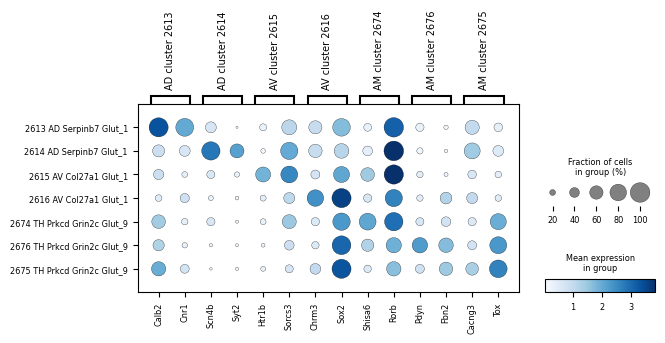

In [22]:
fig_curated = sc.pl.dotplot(adata_ATN,
                            markers_manual_ATN,
                            groupby='cluster', 
                            dendrogram=False,
                            cmap='Blues', #cc.cm.blues, cc.cm.CET_CBL3_r
                            var_group_positions=var_group_positions,
                            var_group_labels=var_group_labels,
                            var_group_rotation=90,
                            return_fig=True,
                            )

fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN.pdf',
                    transparent=True, bbox_inches='tight')
# fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN.png',
#                     transparent=True, bbox_inches='tight')

## Fig. 3E-G | Gene expression of cluster DEGs in the ATN

In [113]:
sections_ATN_clusters = [8.0, 7.8]
taxonomy_level = 'cluster'

# set kwargs for annotated cluster plots
kwargs_cluster_annotations = dict(
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    boundary_img=ccf_boundaries_left,
    bg_cells=adata_th_left.obs,
    point_hue=taxonomy_level,
    point_palette=abc_palettes[taxonomy_level],
    legend='cells',
    point_size=4,
    figsize=(1.75,1.5),
    face_palette=None,
    edge_color='silver'
    )

# set kwargs for gene expression plots
kwargs_ATN_expr = dict(
    sections=sections_ATN_clusters,
    boundary_img=ccf_boundaries_left,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    cmap='Blues',
    cb_vmin_vmax=(0,7),
    point_size=3,
    edge_color='silver', # CCF shape boundary color
    edgecolors='silver', # marker edge color
    linewidths=0.1,
    figsize=(1.75,1.5),
    show_axes=False,
    )

### Fig. 3E | Gene expression of AD cluster DEGs

In [138]:
# AD clusters
nuclei_highlight = ['AD']

custom_xy_lims_AD = [4.4, 5.0, 5.55, 4.55]  # manually set zoom so the two sections' 
                                            # plots are the same size
                                            
obs_annot = abc.get_obs_from_annotated_clusters(nuclei_highlight, adata_th_left.obs)

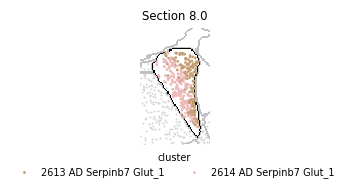

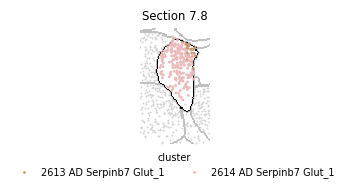

In [139]:
# AD clusters
for sec in sections_ATN_clusters:
    figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                        ccf_images_left,
                                        ccf_highlight=nuclei_highlight,
                                        sections=[sec],
                                        custom_xy_lims=custom_xy_lims_AD,
                                        **kwargs_cluster_annotations)
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight[0]}_z{int(sec*10)}.pdf', 
                        transparent=True, bbox_inches='tight')
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight[0]}_z{int(sec*10)}.png', 
                        transparent=True, bbox_inches='tight', dpi=1200)

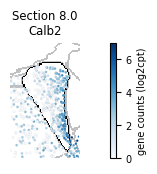

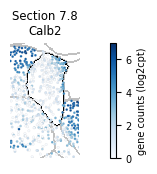

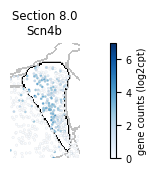

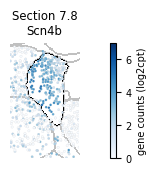

In [140]:
# AD DEGs
for gene in markers_manual_ATN[:3:2]:
    figs = cplots.plot_expression_ccf(adata_th_left, 
                               gene, 
                               ccf_images_left,
                               highlight=nuclei_highlight,
                            #    zoom_to_highlighted=True,
                               custom_xy_lims=custom_xy_lims_AD,
                               **kwargs_ATN_expr)
    for i, fig in enumerate(figs):
        fig.savefig(f'{results_dir}/degs_ATN_AD_{gene}_z{int(sections_to_plot[i]*10)}.pdf',
                    transparent=True, bbox_inches='tight', dpi=1200)
        fig.savefig(f'{results_dir}/degs_ATN_AD_{gene}_z{int(sections_to_plot[i]*10)}.png',
                    transparent=True, bbox_inches='tight', dpi=1200)

### Fig. 3F | Gene expression of AV cluster DEGs

In [141]:
# AV clusters
nuclei_highlight = ['AV']

custom_xy_lims_AV = [4.0, 5.0, 5.90, 4.75]  # manually set zoom so the two sections' 
                                            # plots are the same size
                                            
obs_annot = abc.get_obs_from_annotated_clusters(nuclei_highlight, adata_th_left.obs)

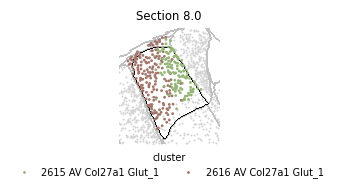

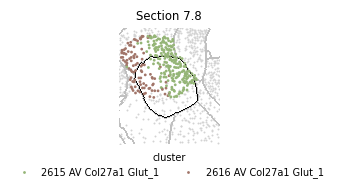

In [142]:
# AV clusters
for sec in sections_ATN_clusters:
    figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                        ccf_images_left,
                                        ccf_highlight=nuclei_highlight,
                                        sections=[sec],
                                        custom_xy_lims=custom_xy_lims_AV,
                                        **kwargs_cluster_annotations)
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight[0]}_z{int(sec*10)}.pdf', 
                        transparent=True, bbox_inches='tight')
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight[0]}_z{int(sec*10)}.png', 
                        transparent=True, bbox_inches='tight', dpi=1200)

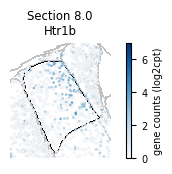

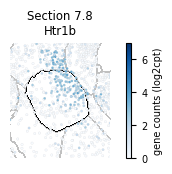

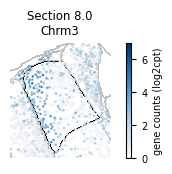

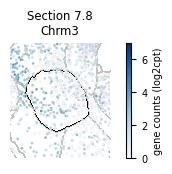

In [143]:
# AV DEGs
for gene in markers_manual_ATN[4:8:2]:
    figs = cplots.plot_expression_ccf(adata_th_left, 
                               gene, 
                               ccf_images_left,
                               highlight=nuclei_highlight,
                            #    zoom_to_highlighted=True,
                               custom_xy_lims=custom_xy_lims_AV,
                               **kwargs_ATN_expr)
    for i, fig in enumerate(figs):
        fig.savefig(f'{results_dir}/degs_ATN_{nuclei_highlight[0]}_{gene}_z{int(sections_to_plot[i]*10)}.pdf',
                    transparent=True, bbox_inches='tight', dpi=1200)
        fig.savefig(f'{results_dir}/degs_ATN_{nuclei_highlight[0]}_{gene}_z{int(sections_to_plot[i]*10)}.png',
                    transparent=True, bbox_inches='tight', dpi=1200)


In [149]:
# AM clusters
nuclei_annot = ['AM']
nuclei_highlight = ['AMd', 'AMv']

custom_xy_lims_AM = [4.35, 5.3, 6.35, 5.3]  # manually set zoom so the two sections' 
                                            # plots are the same size
                                            
obs_annot = abc.get_obs_from_annotated_clusters(nuclei_annot, adata_th_left.obs)

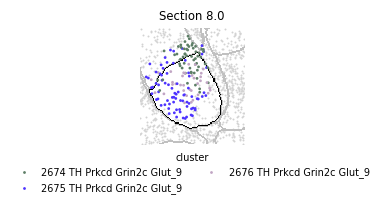

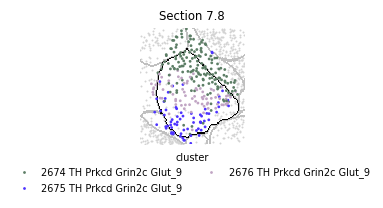

In [153]:
# AM clusters
for sec in sections_ATN_clusters:
    figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                        ccf_images_left,
                                        ccf_highlight=nuclei_highlight,
                                        sections=[sec],
                                        custom_xy_lims=custom_xy_lims_AM,
                                        **kwargs_cluster_annotations)
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight[0]}_z{int(sec*10)}.pdf', 
                        transparent=True, bbox_inches='tight')
    figs_annot[0].savefig(f'{results_dir}/fig3_cluster_annotations_{nuclei_highlight[0]}_z{int(sec*10)}.png', 
                        transparent=True, bbox_inches='tight', dpi=1200)

### Fig. 3G | Gene expression of AM cluster DEGs

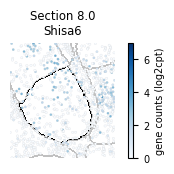

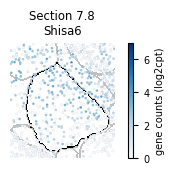

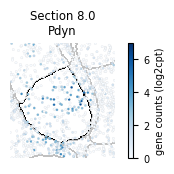

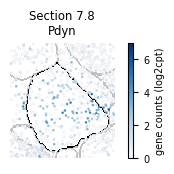

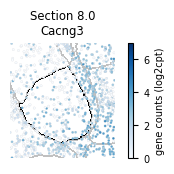

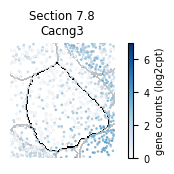

In [164]:
# AM DEGs
for gene in markers_manual_ATN[8::2]:
    figs = cplots.plot_expression_ccf(
                                adata_th_left, 
                                gene, 
                                ccf_images_left,
                                highlight=nuclei_highlight,
                                #    zoom_to_highlighted=True,
                                custom_xy_lims=custom_xy_lims_AM,
                                **kwargs_ATN_expr)
    
    for i, fig in enumerate(figs):
        fig.savefig(f'{results_dir}/degs_ATN_{nuclei_annot[0]}_{gene}_z{int(sections_to_plot[i]*10)}.pdf',
                    transparent=True, bbox_inches='tight', dpi=1200)
        fig.savefig(f'{results_dir}/degs_ATN_{nuclei_annot[0]}_{gene}_z{int(sections_to_plot[i]*10)}.png',
                    transparent=True, bbox_inches='tight', dpi=1200)

## Alt. Fig. 3E-G | left hemi, two sections

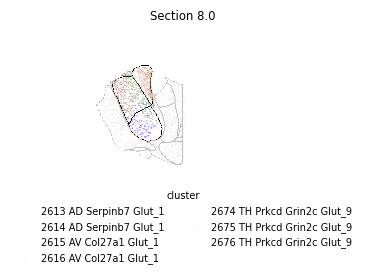

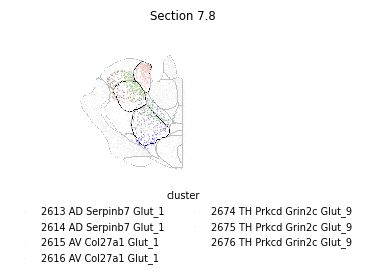

In [ ]:
# get the cluster annotations for the nucleus of interest
nucleus = ['AD', 'AM', 'AV']
obs_th_left = adata_th_left.obs.copy()
obs_annot = abc.get_obs_from_annotated_clusters(nucleus, obs_th_left)

# Let's look at the cell types in the ATN in one sample section
sections_to_plot = [8.0, 7.8]
nuclei_highlight = ['AD', 'AMd', 'AMv', 'AV', 'AV']
taxonomy_level = 'cluster'

plt.rcParams.update({'font.size': 7})
figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                    ccf_images_left,
                                    boundary_img=ccf_boundaries_left,
                                    bg_cells=obs_th_left, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=sections_to_plot,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    **kwargs_cluster_annotations)

for i, sec in enumerate(sections_to_plot):
    sec_str = int(sec*10)
    figs_annot[i].savefig(f'{results_dir}/fig2f_cluster_annotations_z{sec_str}_ATN_left.pdf',
                        transparent=True, bbox_inches='tight')
    figs_annot[i].savefig(f'{results_dir}/fig2f_cluster_annotations_z{sec_str}_ATN_left.png',
                        transparent=True, bbox_inches='tight', dpi=1200)

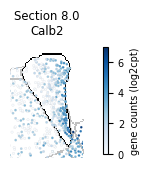

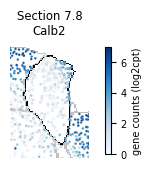

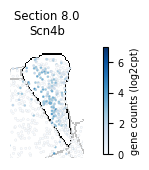

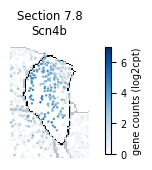

In [ ]:
rcParams['image.composite_image'] = False

kwargs_ATN_expr = dict(
    sections=sections_to_plot,
    zoom_to_highlighted=True,
    boundary_img=ccf_boundaries_left,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    cmap='Blues',
    cb_vmin_vmax=(0,7),
    point_size=3,
    edge_color='silver', # CCF shape boundary color
    edgecolors='silver', # marker edge color
    linewidths=0.1,
    figsize=(1.5,1.5),
    )

# AD DEGs
for gene in markers_manual_ATN[:3:2]:
    figs = cplots.plot_expression_ccf(adata_th_left, 
                               gene, 
                               ccf_images_left,
                               highlight=['AD'],
                               **kwargs_ATN_expr)
    for i, fig in enumerate(figs):
        fig.savefig(f'{results_dir}/degs_ATN_AD_{gene}_z{int(sections_to_plot[i]*10)}.pdf',
                    transparent=True, bbox_inches='tight', dpi=1200)
        fig.savefig(f'{results_dir}/degs_ATN_AD_{gene}_z{int(sections_to_plot[i]*10)}.png',
                    transparent=True, bbox_inches='tight', dpi=1200)

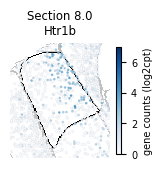

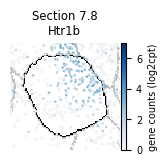

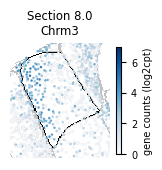

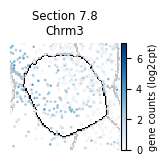

In [ ]:
# AV DEGs
for gene in markers_manual_ATN[4:8:2]:
    figs = cplots.plot_expression_ccf(adata_th_left, 
                               gene, 
                               ccf_images_left,
                               highlight=['AV'],
                               **kwargs_ATN_expr)
    for i, fig in enumerate(figs):
        fig.savefig(f'{results_dir}/degs_ATN_AV_{gene}_z{int(sections_to_plot[i]*10)}.pdf',
                    transparent=True, bbox_inches='tight', dpi=1200)
        fig.savefig(f'{results_dir}/degs_ATN_AV_{gene}_z{int(sections_to_plot[i]*10)}.png',
                    transparent=True, bbox_inches='tight', dpi=1200)

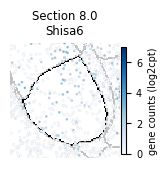

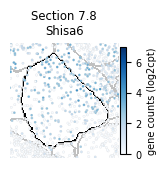

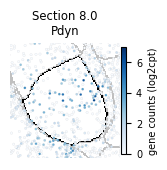

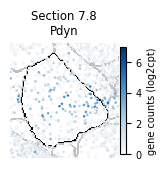

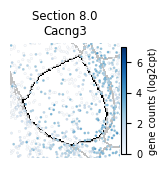

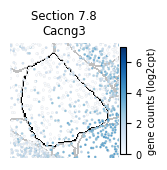

In [ ]:
# AM DEGs
for gene in markers_manual_ATN[8::2]:
    figs = cplots.plot_expression_ccf(adata_th_left, 
                               gene, 
                               ccf_images_left,
                               highlight=['AMd', 'AMv'],
                               **kwargs_ATN_expr)
    for i, fig in enumerate(figs):
        fig.savefig(f'{results_dir}/degs_ATN_AM_{gene}_z{int(sections_to_plot[i]*10)}.pdf',
                    transparent=True, bbox_inches='tight', dpi=1200)
        fig.savefig(f'{results_dir}/degs_ATN_AM_{gene}_z{int(sections_to_plot[i]*10)}.png',
                    transparent=True, bbox_inches='tight', dpi=1200)